In [1]:
import pickle
import rootutils
from pathlib import Path
import sys

root_path = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)

src_path = Path(root_path) / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from tree_builder import TreeBuilder


In [2]:
# --- Parâmetros ---
EMBEDDINGS_FILE = root_path / "data" / "lfw_embeddings_processados.pkl"
OUTPUT_TREE_FILE = root_path / "data" / "identity_tree.pkl"
MAX_LEAF_SIZE = 1 

# --- Verificações ---
EMBEDDINGS_FILE = root_path / "data" / "lfw_embeddings_processados.pkl"
OUTPUT_TREE_FILE = root_path / "data" / "identity_tree.pkl"
MAX_LEAF_SIZE = 1 

# --- Verificação ---
assert EMBEDDINGS_FILE.exists(), f"ERRO: Arquivo de embeddings não encontrado em '{EMBEDDINGS_FILE}'"

# --- Execução ---
builder = TreeBuilder(
    embeddings_path=EMBEDDINGS_FILE,
    max_leaf_size=MAX_LEAF_SIZE
)

builder.build_tree(qtd_identities=1200)  


Starting TreeBuilder...
   -> Loading embeddings from 'C:\Users\pedro\OneDrive\Documentos\git\h-asl-thesis\data\lfw_embeddings_processados.pkl'...
   -> Building DataFrame from 'names' and 'embeddings' keys...
   -> Calculating mean embeddings for each identity...
   -> Dados preparados. 1680 identidades únicas encontradas.

 Iniciando a construção da Árvore Hierárquica...
I-> Dividindo nó com 1200 identidades no nível 0...
  I-> Dividindo nó com 615 identidades no nível 1...
    I-> Dividindo nó com 265 identidades no nível 2...
      I-> Dividindo nó com 124 identidades no nível 3...
        I-> Dividindo nó com 73 identidades no nível 4...
          I-> Dividindo nó com 25 identidades no nível 5...
            I-> Dividindo nó com 8 identidades no nível 6...
              I-> Dividindo nó com 3 identidades no nível 7...
                L-> Nó Folha criado com a identidade: Dexter Jackson
                I-> Dividindo nó com 2 identidades no nível 8...
                  L-> Nó Folha 

In [3]:
# builder.visualize_tree_as_graph()

In [4]:
builder.find_identity('Vladimir Putin')

LLLRRRRLRL


In [5]:
root_node = builder.root

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import random

from src.models.losses.asl import AxialSpheresLoss3Axis
from src.models.neural_networks.node_network import NodeNetwork

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cpu


In [8]:
# root_node = builder.root

# identities_left = root_node.left.identities
# identities_right = root_node.right.identities
# embeddings_left = [builder.embeddings_map[name] for name in identities_left]
# embeddings_right = [builder.embeddings_map[name] for name in identities_right]
# labels_left = [0] * len(embeddings_left)
# labels_right = [1] * len(embeddings_right)
# all_embeddings_list = embeddings_left + embeddings_right
# all_labels_list = labels_left + labels_right
# all_data = torch.tensor(np.array(all_embeddings_list).astype(np.float32), dtype=torch.float)
# all_labels = torch.tensor(all_labels_list, dtype=torch.long)

In [9]:
# Seu root_node e builder já estão disponíveis
root_node = builder.root

# --- 1. Dados CONHECIDOS (Labels 0 e 1) ---
# (Isso é o mesmo que fizemos antes)

identities_left = root_node.left.identities
identities_right = root_node.right.identities

embeddings_left = [builder.embeddings_map[name] for name in identities_left]
embeddings_right = [builder.embeddings_map[name] for name in identities_right]

labels_left = [0] * len(embeddings_left)
labels_right = [1] * len(embeddings_right)

print(f"Dados Conhecidos: {len(labels_left)} (Esquerda) + {len(labels_right)} (Direita) = {len(labels_left) + len(labels_right)}")

# --- 2. Dados DESCONHECIDOS (Label -1) ---
# (Esta é a parte nova)

# Pegar o set de TODAS as identidades carregadas do arquivo pkl
all_identities_set = set(builder.mean_embeddings_df['nome'])

# Pegar o set das 500 identidades que estão NA ÁRVORE
known_identities_set = set(root_node.identities)

# A diferença (set subtraction) nos dá exatamente as identidades "de fora"
unknown_identities_names = all_identities_set - known_identities_set

# Buscar os embeddings para essas identidades
embeddings_unknown = random.sample([builder.embeddings_map[name] for name in unknown_identities_names], k=400)

# O label crucial: -1
labels_unknown = [-1] * len(embeddings_unknown)

print(f"Dados Desconhecidos: {len(labels_unknown)} (Label -1)")

# --- 3. Combinar e Criar Tensores ---

all_embeddings_list = embeddings_left + embeddings_right + embeddings_unknown
all_labels_list = labels_left + labels_right + labels_unknown

# Converter para tensores
all_data = torch.tensor(np.array(all_embeddings_list).astype(np.float32), dtype=torch.float)
all_labels = torch.tensor(all_labels_list, dtype=torch.long)

print(f"\nTensor 'all_data' final com shape: {all_data.shape}")
print(f"Tensor 'all_labels' final com shape: {all_labels.shape}")

# Garantir que o IN_FEATURES está correto (não deve ter mudado)
IN_FEATURES = all_data.shape[1]
print(f"Dimensão de entrada (IN_FEATURES): {IN_FEATURES}")

Dados Conhecidos: 615 (Esquerda) + 585 (Direita) = 1200
Dados Desconhecidos: 400 (Label -1)

Tensor 'all_data' final com shape: torch.Size([1600, 512])
Tensor 'all_labels' final com shape: torch.Size([1600])
Dimensão de entrada (IN_FEATURES): 512


In [10]:
BATCH_SIZE = 32   
TEST_SPLIT = 0.2  

# 1. Criar o TensorDataset
# Isso junta os embeddings e os labels
dataset = TensorDataset(all_data, all_labels)
print(f"Dataset total criado com {len(dataset)} amostras.")

# 2. Dividir em Treino e Teste
train_size = int((1.0 - TEST_SPLIT) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Tamanho do conjunto de Treino: {len(train_dataset)} amostras")
print(f"Tamanho do conjunto de Teste:  {len(test_dataset)} amostras")

# 3. Criar os DataLoaders
# O train_loader embaralha (shuffle=True) para garantir um bom aprendizado
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# O test_loader não precisa embaralhar (shuffle=False)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\nDataLoaders criados com BATCH_SIZE={BATCH_SIZE}.")

Dataset total criado com 1600 amostras.
Tamanho do conjunto de Treino: 1280 amostras
Tamanho do conjunto de Teste:  320 amostras

DataLoaders criados com BATCH_SIZE=32.


In [11]:
LEARNING_RATE = 0.001

model = NodeNetwork().to(DEVICE)

criterion = AxialSpheresLoss3Axis()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


print("--- Componentes de Treinamento Prontos ---")
print(f"Modelo: {model.__class__.__name__}")
print(f"  - Parâmetros de Entrada: 512")
print(f"  - Parâmetros de Saída: 3")
print(f"\nFunção de Custo: {criterion.__class__.__name__}")
print(f"  - Alpha: {criterion.alpha}")
print(f"\nOtimizador: {optimizer.__class__.__name__}")
print(f"  - Learning Rate: {LEARNING_RATE}")

# (Opcional) Imprimir a arquitetura do modelo
print("\nArquitetura do Modelo:")
print(model)

--- Componentes de Treinamento Prontos ---
Modelo: NodeNetwork
  - Parâmetros de Entrada: 512
  - Parâmetros de Saída: 3

Função de Custo: AxialSpheresLoss3Axis
  - Alpha: 5.0

Otimizador: Adam
  - Learning Rate: 0.001

Arquitetura do Modelo:
NodeNetwork(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.1)
  (fc_out): Linear(in_features=512, out_features=3, bias=True)
)


In [12]:
import time 


NUM_EPOCHS = 40 


history = {
    'train_loss': [],
    'test_loss': [],
    'test_accuracy': []
}

print(f"Iniciando treinamento por {NUM_EPOCHS} épocas...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    # ===================================
    # --- 1. FASE DE TREINAMENTO ---
    # ===================================
    
    model.train()
    
    running_train_loss = 0.0
    
    # Loop Interno: por Lote (Batch)
    for embeddings, labels in train_loader:
        # Mover dados para o DEVICE (CPU ou GPU)
        embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
        
        # --- O Ciclo de 5 Passos do Treino ---
        
        # 1. Zerar os gradientes acumulados
        optimizer.zero_grad()
        
        # 2. Forward Pass: Passar os dados pela rede
        # Input: [32, 512] -> Output: [32, 2]
        logits = model(embeddings)
        
        # 3. Calcular a Loss
        loss = criterion(logits, labels)
        
        # 4. Backward Pass: Calcular os gradientes
        loss.backward()
        
        # 5. Otimizar: Atualizar os pesos da rede
        optimizer.step()
        
        # Acumular a loss (loss.item() pega o valor numérico da loss)
        # Multiplicamos pelo tamanho do lote para fazer a média correta no final
        running_train_loss += loss.item() * embeddings.size(0)

    # Calcular a loss média de treino para esta época
    epoch_train_loss = running_train_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    # ===================================
    # --- 2. FASE DE VALIDAÇÃO (TESTE) ---
    # ===================================
    
    # Coloca o modelo em modo de avaliação (desativa o Dropout)
    model.eval()
    
    running_test_loss = 0.0
    correct_known_preds = 0 # <-- MUDANÇA: Renomeado para clareza
    total_known_preds = 0   # <-- MUDANÇA: Renomeado para clareza
    
    # Desativa o cálculo de gradientes para economizar memória e tempo
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
            
            # Forward pass
            logits = model(embeddings)
            
            # Calcular Loss (para todas as amostras, incluindo desconhecidos)
            loss = criterion(logits, labels)
            running_test_loss += loss.item() * embeddings.size(0)
            
            # --- INÍCIO DA CORREÇÃO DA ACURÁCIA ---
            
            # 1. Criar uma máscara para pegar APENAS labels conhecidos (>= 0)
            known_mask_batch = (labels >= 0)
            
            # 2. Só calcular acurácia se houver conhecidos neste lote
            if known_mask_batch.sum() > 0:
                
                # 3. Filtrar logits e labels usando a máscara
                logits_known_batch = logits[known_mask_batch]
                labels_known_batch = labels[known_mask_batch]
                
                # 4. Calcular predições (argmax) APENAS nos logits conhecidos
                preds_known = torch.argmax(logits_known_batch, dim=1)
                
                # 5. Contar acertos comparando predições (0 ou 1) com labels (0 ou 1)
                correct_known_preds += (preds_known == labels_known_batch).sum().item()
                
                # 6. Incrementar o total APENAS pelo número de labels conhecidos
                total_known_preds += labels_known_batch.size(0)
            
            # --- FIM DA CORREÇÃO DA ACURÁCIA ---

    # Calcular as métricas médias de teste para esta época
    epoch_test_loss = running_test_loss / len(test_dataset) # Loss total está correta
    
    # Acurácia agora é calculada corretamente (evita divisão por zero se não houver conhecidos)
    epoch_test_acc = (correct_known_preds / total_known_preds) if total_known_preds > 0 else 0.0
    
    history['test_loss'].append(epoch_test_loss)
    history['test_accuracy'].append(epoch_test_acc)

    # ===================================
    # --- 3. IMPRIMIR RESULTADOS DA ÉPOCA ---
    # ===================================
    
    # <-- MUDANÇA: Atualizado para mostrar os totais corretos
    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Acc (Known): {epoch_test_acc:.4f} " # <-- MUDANÇA: Label atualizado
          f"({correct_known_preds}/{total_known_preds})")

end_time = time.time()
print("\nTreinamento concluído!")
print(f"Tempo total: {end_time - start_time:.2f} segundos")

Iniciando treinamento por 40 épocas...
Epoch [01/40] | Train Loss: 6.7545 | Test Loss: 6.4966 | Test Acc (Known): 0.8571 (204/238)
Epoch [02/40] | Train Loss: 3.4534 | Test Loss: 5.4449 | Test Acc (Known): 0.8361 (199/238)
Epoch [03/40] | Train Loss: 2.4155 | Test Loss: 5.5895 | Test Acc (Known): 0.8487 (202/238)
Epoch [04/40] | Train Loss: 1.5834 | Test Loss: 6.3848 | Test Acc (Known): 0.7479 (178/238)
Epoch [05/40] | Train Loss: 1.0720 | Test Loss: 6.7492 | Test Acc (Known): 0.7311 (174/238)
Epoch [06/40] | Train Loss: 0.6863 | Test Loss: 6.8316 | Test Acc (Known): 0.7227 (172/238)
Epoch [07/40] | Train Loss: 0.4591 | Test Loss: 6.8078 | Test Acc (Known): 0.7269 (173/238)
Epoch [08/40] | Train Loss: 0.1939 | Test Loss: 6.6245 | Test Acc (Known): 0.7353 (175/238)
Epoch [09/40] | Train Loss: 0.0076 | Test Loss: 6.3927 | Test Acc (Known): 0.7395 (176/238)
Epoch [10/40] | Train Loss: -0.1574 | Test Loss: 6.3928 | Test Acc (Known): 0.7185 (171/238)
Epoch [11/40] | Train Loss: -0.2593 | Te

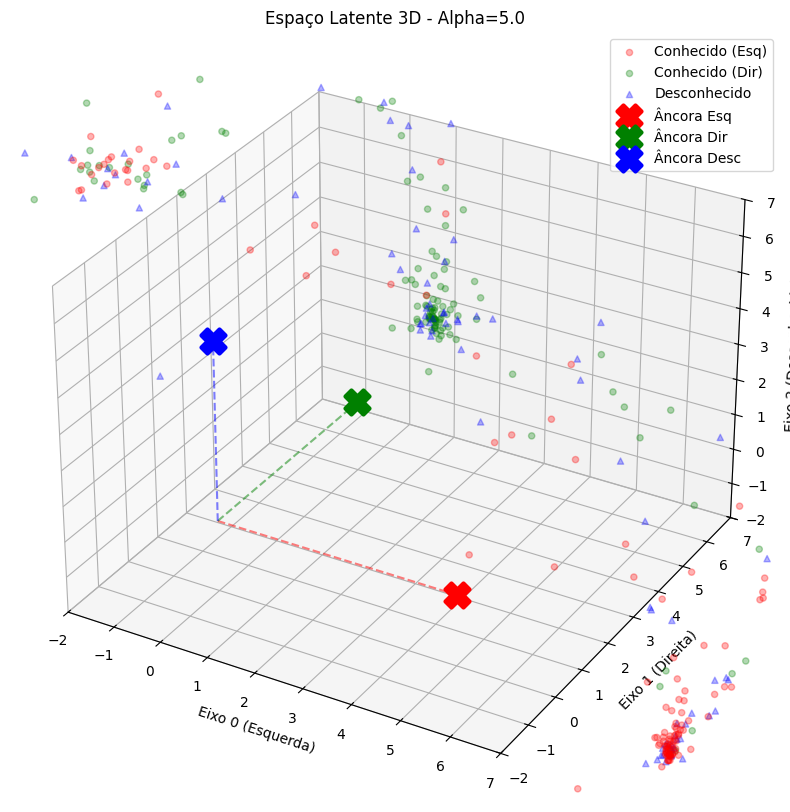

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar_espaco_3d(model, loader, device, alpha=5.0):
    model.eval()
    logits_list = []
    labels_list = []

    # 1. Coletar todos os logits
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(labels.numpy())

    logits_np = np.concatenate(logits_list, axis=0)
    labels_np = np.concatenate(labels_list, axis=0)

    # 2. Configurar o Plot 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 3. Definir cores e marcadores
    # Classes: 0=Esq (Vermelho), 1=Dir (Verde), -1=Desc (Azul)
    cores = {0: 'red', 1: 'green', -1: 'blue'}
    nomes = {0: 'Conhecido (Esq)', 1: 'Conhecido (Dir)', -1: 'Desconhecido'}
    marcadores = {0: 'o', 1: 'o', -1: '^'} # Triângulos para desconhecidos

    # 4. Plotar cada ponto
    for cls in [0, 1, -1]:
        mask = (labels_np == cls)
        if mask.sum() > 0:
            ax.scatter(logits_np[mask, 0], logits_np[mask, 1], logits_np[mask, 2],
                       c=cores[cls], marker=marcadores[cls], label=nomes[cls], alpha=0.3)

    # 5. Plotar os Âncoras (Alvos Ideais) com 'X' gigante
    ax.scatter([alpha], [0], [0], c='red', marker='X', s=300, linewidth=3, label='Âncora Esq')
    ax.scatter([0], [alpha], [0], c='green', marker='X', s=300, linewidth=3, label='Âncora Dir')
    ax.scatter([0], [0], [alpha], c='blue', marker='X', s=300, linewidth=3, label='Âncora Desc')

    # (Opcional) Linhas da origem até os âncoras para dar perspectiva
    ax.plot([0, alpha], [0, 0], [0, 0], 'r--', alpha=0.5)
    ax.plot([0, 0], [0, alpha], [0, 0], 'g--', alpha=0.5)
    ax.plot([0, 0], [0, 0], [0, alpha], 'b--', alpha=0.5)

    # 6. Ajustes finais
    ax.set_xlabel('Eixo 0 (Esquerda)')
    ax.set_ylabel('Eixo 1 (Direita)')
    ax.set_zlabel('Eixo 2 (Desconhecido)')
    ax.set_title(f'Espaço Latente 3D - Alpha={alpha}')
    ax.legend()
    
    # Define limites iguais para não distorcer a visualização
    limite = alpha + 2
    ax.set_xlim([-2, limite])
    ax.set_ylim([-2, limite])
    ax.set_zlim([-2, limite])

    plt.show()


visualizar_espaco_3d(model, test_loader, DEVICE, alpha=5.0)

Gerando gráficos de histórico de treinamento...


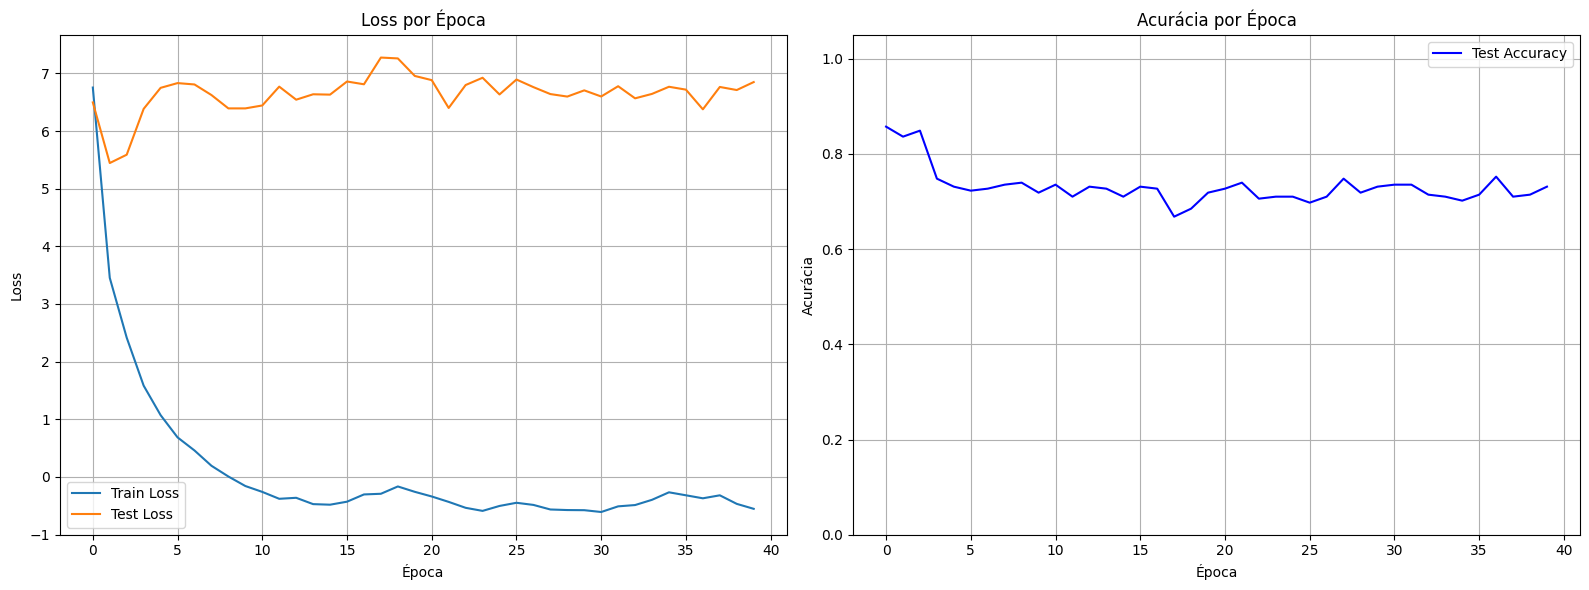

Gerando gráfico de dispersão dos logits (A Prova)...


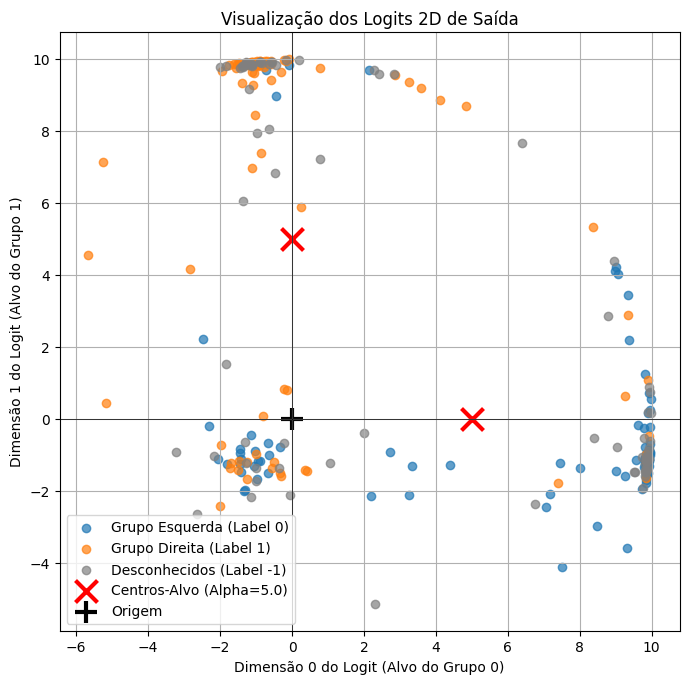

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- Gráfico 1: Curvas de Loss e Acurácia ---
# Este gráfico nos mostra a *história* do treinamento.
print("Gerando gráficos de histórico de treinamento...")

# Criar uma figura com duas subtramas (uma ao lado da outra)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subtrama 1: Loss
# Aqui vemos se a rede está "aprendendo" (loss caindo).
# Queremos que Train Loss e Test Loss caiam juntas.
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_title('Loss por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Subtrama 2: Acurácia
# Aqui vemos o desempenho no mundo real (dados de teste).
# Queremos que ela suba e fique estável no valor mais alto possível.
ax2.plot(history['test_accuracy'], label='Test Accuracy', color='blue')
ax2.set_title('Acurácia por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia')
ax2.set_ylim(0, 1.05) # Forçar eixo Y de 0 a 100%
ax2.legend()
ax2.grid(True)

plt.tight_layout() # Ajusta o espaçamento
plt.show()


# --- Gráfico 2: A Prova Final (Scatter Plot 2D dos Logits) ---
# Este é o gráfico mais importante. É a prova visual de que a ASL funcionou.
print("Gerando gráfico de dispersão dos logits (A Prova)...")

# --- Passo 2a: Coletar os Logits de Teste ---
# Precisamos coletar TODOS os logits e labels do conjunto de teste
all_test_logits = []
all_test_labels = []

# Colocar modelo em modo de avaliação (desliga dropout)
model.eval()
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(DEVICE)
        
        logits = model(embeddings)
        
        # Mover de volta para a CPU e numpy para plotar
        all_test_logits.append(logits.cpu().numpy())
        all_test_labels.append(labels.cpu().numpy())

# Concatenar os resultados de todos os lotes
final_logits = np.concatenate(all_test_logits)
final_labels = np.concatenate(all_test_labels)

# Pegar o valor de 'alpha' da sua loss
alpha = criterion.alpha

# --- Passo 2b: Filtrar os Logits por Label ---
# Separamos os logits baseados em seus *labels verdadeiros*
logits_left = final_logits[final_labels == 0]
logits_right = final_logits[final_labels == 1]
logits_unknown = final_logits[final_labels == -1]
# (Se tivéssemos desconhecidos (label -1), os filtraríamos aqui também)

# --- Passo 2c/2d: Plotar os Grupos e os Alvos ---
plt.figure(figsize=(8, 14))

# Plotar os grupos
if len(logits_left) > 0:
    plt.scatter(logits_left[:, 0], logits_left[:, 1], 
                label='Grupo Esquerda (Label 0)', alpha=0.7)
if len(logits_right) > 0:
    plt.scatter(logits_right[:, 0], logits_right[:, 1], 
                label='Grupo Direita (Label 1)', alpha=0.7)
if len(logits_unknown) > 0:
    plt.scatter(logits_unknown[:, 0], logits_unknown[:, 1], 
                label='Desconhecidos (Label -1)', alpha=0.7, c='gray')

# Plotar os centros-alvo (cruzes vermelhas)
# A loss tentou empurrar os pontos para cá.
plt.scatter([alpha, 0], [0, alpha], 
            marker='x', s=250, c='red', 
            label=f'Centros-Alvo (Alpha={alpha})',
            linewidth=3)

# Plotar a origem (alvo dos desconhecidos, caso existam)
plt.scatter(0, 0, marker='+', s=250, c='black', label='Origem', linewidth=3)

plt.title('Visualização dos Logits 2D de Saída')
plt.xlabel('Dimensão 0 do Logit (Alvo do Grupo 0)')
plt.ylabel('Dimensão 1 do Logit (Alvo do Grupo 1)')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [15]:
logits_unknown

array([[ 9.89891   , -1.1066545 , -0.8870717 ],
       [ 1.0657076 , -1.229387  ,  9.866756  ],
       [ 9.828712  , -1.0941449 , -1.4829895 ],
       [ 9.891123  , -1.0264328 , -1.0545607 ],
       [-1.2691225 , -1.2247701 ,  9.843234  ],
       [ 9.826506  , -1.4076174 , -1.2076389 ],
       [-0.8857118 ,  9.93498   ,  0.71532047],
       [ 9.802457  , -1.2443101 , -1.5373785 ],
       [-1.285244  ,  9.863054  , -1.0335853 ],
       [ 9.947344  ,  0.7409805 , -0.7080368 ],
       [ 9.833581  , -1.0907562 , -1.452909  ],
       [-1.1835303 ,  9.855476  , -1.2119559 ],
       [-0.64208144,  9.866648  ,  1.4956529 ],
       [-1.3592606 ,  9.823906  , -1.2819071 ],
       [ 9.8533945 , -1.1268411 , -1.2809573 ],
       [-1.0155818 , -1.366397  ,  9.8540125 ],
       [ 0.76551765,  7.215927  ,  6.880726  ],
       [-1.8275216 ,  1.5318394 ,  9.71152   ],
       [ 9.5358305 , -1.470387  ,  2.6279056 ],
       [-0.5832391 ,  9.938196  , -0.9444981 ],
       [-1.2723826 ,  9.91848   , -0.069